# Reinforcement Learning for Gomoku Game - Source

*by Jim Xu, Dec. 2017*

### Reinforcement Learning for Gomoku Game - [Report](https://nbviewer.jupyter.org/github/GrEedWish/csu-cs-440/blob/master/Project-Report.ipynb)

In [3]:
import numpy as np
import random
import copy

First, define the game board and rules.

In [4]:
class GomokuGame(object):
    
    def __init__(self, size = 5, limit = 4, test=False):
        self.boardSize = size
        self.limit = limit
        self.board = np.zeros(shape=(self.boardSize, self.boardSize))
        self.player = 1
        self.playerLookAHead = self.player
        self.move = None
        self.movesExplored = 0
        
        if test:
            self.board = np.array([0,0,0,0,1,0,1,0,2,0,0,1,2,0,1,2,0,0,1,0,2,0,0,0,1]).reshape(5,5)
        
    def __str__(self):
        return str(self.board)
    
    def setGame(self, board, player, playerLookAHead, limit = 4):
        self.board = board
        self.player = player
        self.playerLookAHead = playerLookAHead
        self.limit = limit
    
    def getAllMoves(self, All = False):
        # return valid moves on board
        # as a list, contains x,y tuples for each position
        # e.g. [(x1,y1), (x2, y2) ... (xn, yn)]
        # ALL ? Return All valid or All positions in board
        if All:
            return [(x, y) for x in range(game.boardSize) for y in range(game.boardSize)]
        else:
            return [tuple(move) for move in (np.asarray(np.where(self.board == 0)).T)]
    
    def getBoardScore(self, player = None, move = None, lookBack = False):
        
        '''
        Using given knowledge calculating the proposed value for a given move
        takeIn: current player (LookAhead), Move
        Return: Value (int) for this move
        blank(0): +1 [consecutive + 1]
        same: +2 (diag : +1) [consecutive + 2]
        initialize Score = penalty: abs(self.size/2-xCor) + abs(self.size/2-yCor)
        
        '''
        if lookBack:
            player = 1 if game.playerLookAHead == 2 else 2
            move = self.move
        
        xCor, yCor = move[0], move[1]
        
        if not lookBack:
            if game.board[xCor, yCor] != 0:
                # hard-code least possible score
                return None

        game.board[xCor, yCor] = player
        xInc = [1,0,1,1]
        yInc = [0,1,1,-1]
        bestScore = 0
        oriScore = - 2 * (abs(int(self.boardSize/2)-xCor) ** 2 + abs(int(self.boardSize/2)-yCor) ** 2)
        for index in range(0,4):
            score = oriScore
            consecutive_0 = 0
            consecutive_p = 0
            for i in range(-self.limit, self.limit+1):
                newXCor = xCor + i*xInc[index]
                newYCor = yCor + i*yInc[index]
                if newXCor < 0 or newYCor < 0:
                    continue
                if newXCor >= self.boardSize or newYCor >= self.boardSize:
                    continue
                if self.board[newXCor, newYCor] == player:
                    score += (2 + int((index+2)/2) + 3 * consecutive_p)
                    consecutive_p += 1
                elif self.board[newXCor, newYCor] == 0:
                    score += (1 + int((index+2)/2) + 1 * consecutive_0)
                    consecutive_0 += 1
                else:
                    bestScore = max(score, bestScore)
                    score = oriScore
                    consecutive_0 = 0
                    consecutive_p = 0
                bestScore = max(score, bestScore)
        
        if not lookBack: 
            game.board[xCor, yCor] = 0

        return bestScore
    
    def getMovesAround(self, cenMove):
        '''
        Return a list of tuples for moves around a specific opponent move
        '''
        return [tuple(move) for move in (np.asarray(np.where(self.board == 0)).T) 
               if ((move[0] - cenMove[0] <= 1 and move[0] - cenMove[0] >= -1) and
                   (move[1] - cenMove[1] <= 1 and move[1] - cenMove[1] >= -1))]

    def getOptMoves(self, random = True, number = 1):
        """
        get Optimal moves according to each moves score
        from a pool of all possible moves
        Random ? return top # number of best moves
            else : return the best moves
        """
        validMoves = game.getAllMoves()
        scores = np.array([game.getBoardScore(game.playerLookAHead, move) for move in validMoves])
        if random:
            takeOut = min(5, len(scores))
            if number == 1:
                return [tuple(validMoves[np.random.choice(scores.argsort()[-takeOut:])])]
            else:
                takeOut = max(takeOut, number)
                return [tuple(validMoves[i]) for i in (scores.argsort()[-takeOut:])]
        else:
            maxs = max(scores)
            return [tuple(validMoves[i]) for i in np.where(scores == maxs)[0]]
        
    def makeMove(self, move):
        # return the board that results from applying move in board for a given player
        self.movesExplored += 1
        self.move = move
        self.board[move[0], move[1]] = self.playerLookAHead
        self.playerLookAHead = 1 if self.playerLookAHead == 2 else 2
        return game.board
    
    def locations(self, c):
        return [i for i, mark in np.ndenumerate(self.board) if mark == c]
    
    def checkWinner(self, player, move = -1, limit = -1):
        """
        check if the move gives given player a win
        """
        if move == -1: move = self.move
        if limit == -1: limit = self.limit
        if move is None:
            return False
        xCor, yCor = move[0], move[1]
        xInc = [1,1,1,0]
        yInc = [1,-1,0,1]
        for index in range(0,4):
            checkNum = 0
            consecutive_F = False 
            for i in range(-limit, limit+1):
                newXCor = xCor + i*xInc[index]
                newYCor = yCor + i*yInc[index]
                if newXCor < 0 or newYCor < 0:
                    continue
                if newXCor >= self.boardSize or newYCor >= self.boardSize:
                    continue
                if newXCor == xCor and newYCor == yCor:
                    checkNum += 1
                    
                elif self.board[newXCor, newYCor] == player:
                    checkNum += 1
                
                else: 
                    checkNum = 0

                if checkNum == limit:
                    return True
        return False
        
    def getUtility(self):
        if self.checkWinner(1 if self.playerLookAHead == 2 else 2):
            'No winner'
            return -1
        elif 0 not in self.board:
            'No blanks'
            return 0
        else: return None
        
    def isOver(self):
        return self.getUtility() is not None
    
    def changePlayer(self):
        self.player = 1 if self.player == 2 else 2
        self.playerLookAHead = self.player

    def unmakeMove(self, move):
        self.move = None
        self.board[move[0], move[1]] = 0
        self.playerLookAHead = 1 if self.playerLookAHead == 2 else 2

    def getNumberMovesExplored(self):
        return self.movesExplored

In [5]:
def negamaxIDSab(game, depthLimit, alpha=-float('infinity'), beta=float('infinity')):
    bestValue = -float('infinity')
    bestMove = None
    for i in range (1, depthLimit+1):
        value, move = negamaxab(game, i, alpha, beta)
        if value is None:
            continue
        if bestValue < value:
            bestValue = value
            bestMove = move
        if bestValue == 1:
            return bestValue, bestMove
    return bestValue, bestMove

def negamaxab(game, depthLeft, alpha=-float('infinity'), beta=float('infinity')):
    # In the for loop for trying moves, negate and swap the values of alpha and beta, 
    # and the returned value from recursive calls must be negated.
    alpha, beta = -beta, -alpha
    # If at terminal state or depth limit, return utility value and move None
    if game.isOver() or depthLeft == 0:
        return -game.getBoardScore(lookBack = True), None # call to negamax knows the move
    # Find best move and its value from current state
    bestValue, bestMove = None, None
    for move in game.getOptMoves(number = 5):
        # Apply a move to current state      
        game.makeMove(move)
        
        # Use depth-first search to find eventual utility value and back it up.
        #  Negate it because it will come back in context of next player
        value, _ = negamaxab(game, depthLeft-1, alpha, beta)
        
        # Remove the move from current state, to prepare for trying a different move
        game.unmakeMove(move)
        
        value = - value

        if bestValue is None or value > bestValue:
#             print("Update bestValue bestMove", bestValue, bestMove)
            bestValue, bestMove = value, move
        # Update alpha to maximum of bestValue and current alpha.
        alpha = max(bestValue, alpha)
        if alpha >= beta:
            # Do early return if bestScore is greater than or equal to beta.
            return bestValue, bestMove
    if bestValue is None and bestMove is None:
        return 0, game.getOptMoves()[0]
    return bestValue, bestMove

In [6]:
def opponent(game):
    return random.choice(game.getAllMoves())

def playGame(game,opponent,depthLimit):
    print(game)
    while not game.isOver():
        opponentMove = opponent(game)
        game.makeMove(opponentMove)
        print('Player', game.player, 'to', opponentMove)   ### FIXED ERROR IN THIS LINE!
        print(game)
        if not game.isOver():
            game.changePlayer()
            score,move = negamaxIDSab(game,depthLimit)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            print('Player', game.player, 'to', move, 'for score' ,score)
            print(game)
            game.changePlayer()
    print(game.getNumberMovesExplored())

In [7]:
def randomStratage(game):
    return random.choice(game.getAllMoves())

def printBoard(value):
    Vprint = [int(-99) if v is None else v for v in value]
    print('''    {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f}
    -------------------------------------------
    {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f}
    -------------------------------------------
    {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f}
    -------------------------------------------
    {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f}
    -------------------------------------------
    {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f} | {:6.2f}
    '''.format(*Vprint))

Let do some basic examples getting to know the functions of GomokuGame class

In [8]:
game = GomokuGame(size=5,limit=4)

**getBoardScore** is the core function in GomokuGame Class, it provides scores for a given board and calculate each move score based on some human knowledge (NOTE: the score calculation implementation is not perfect here). With the help of scores, we can easier pick perfered moves from those moves with high scores.

Let's take a look at the scores for initial board.

In [9]:
printBoard(np.array([game.getBoardScore(game.playerLookAHead, move) for move in game.getAllMoves(All=True)]))

      6.00 |   7.00 |   9.00 |   7.00 |   6.00
    -------------------------------------------
      7.00 |  18.00 |  15.00 |  18.00 |   7.00
    -------------------------------------------
      9.00 |  15.00 |  22.00 |  15.00 |   9.00
    -------------------------------------------
      7.00 |  18.00 |  15.00 |  18.00 |   7.00
    -------------------------------------------
      6.00 |   7.00 |   9.00 |   7.00 |   6.00
    


**getOptMoves** is another core function in GomokuGame Class, it provides different returns for optimal moves based on scores. It can either return the best move with highest scores, or a random move in the top # of best moves with highest scores, or the top # of best moves with highest scores.

In [10]:
game.getOptMoves(random=False), game.getOptMoves(random = True, number = 1), game.getOptMoves(random = True, number = 5)

([(2, 2)], [(3, 3)], [(3, 1), (3, 3), (1, 3), (1, 1), (2, 2)])

Let's begin the game with the first move (2,2), which looks good to me for my first step.

In [11]:
game.makeMove((2,2))
game.changePlayer()
print(game)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


Then, lets take a look at the scores after I took the first move.

In [12]:
printBoard(np.array([game.getBoardScore(game.playerLookAHead, move) for move in game.getAllMoves(All=True)]))

      1.00 |   7.00 |   9.00 |   7.00 |   1.00
    -------------------------------------------
      7.00 |  13.00 |  15.00 |  13.00 |   7.00
    -------------------------------------------
      9.00 |  15.00 | -99.00 |  15.00 |   9.00
    -------------------------------------------
      7.00 |  13.00 |  15.00 |  13.00 |   7.00
    -------------------------------------------
      1.00 |   7.00 |   9.00 |   7.00 |   1.00
    


According to the table, the best move for my opponent is with **value 15 (one of (1,1), (1,3), (3,1), (3,3))**. However, I want computer gives my opponent an convincing choice for its next move.

**Negamax with Alpha–beta pruning** is used here to find a local optimal move for the opponent from a pool of 5 best move with highest scores.

In [13]:
score,move = negamaxab(game, 3)
score,move

(16, (1, 1))

In [14]:
score,move = negamaxab(game, 5)
score,move

(16, (1, 1))

**While through Negamax with Alpha–beta pruning, the best move is changed to (1,1) with value 13.**

In [15]:
score, opponentMove = negamaxab(game, 3)
game.makeMove(opponentMove)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [16]:
game.isOver(), game.player, game.playerLookAHead

(False, 2, 1)

In [17]:
print(game)

[[ 0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


Now, I will take random moves and my opponent still uses local optimal moves.

In [18]:
game.changePlayer()
move = randomStratage(game)
game.makeMove(move)
game.changePlayer()
print(game)

[[ 0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]


In [19]:
score, opponentMove = negamaxab(game, 3)
game.makeMove(opponentMove)
game.changePlayer()
print(game)

[[ 0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]


In [20]:
print(game)
while not game.isOver():
    move = randomStratage(game)
    if move == None :
        print('move is None. Stopping.')
        break
    game.makeMove(move)
    print('Player', game.player, 'to', move)
    print(game)
    if(game.checkWinner(1)): print("1(I) won")
    if not game.isOver():
        game.changePlayer()
        score, opponentMove = negamaxab(game, 3)
        game.makeMove(opponentMove)
        print('Player', game.player, 'to', opponentMove, 'for score' ,score)
        print(game)
        game.changePlayer()
        if(game.checkWinner(2)): print("2(Opponent) won")
print(game.getNumberMovesExplored())

[[ 0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (0, 0)
[[ 1.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (3, 1) for score 16
[[ 1.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (0, 2)
[[ 1.  0.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 1) for score 22
[[ 1.  2.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (2, 1)
[[ 1.  2.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  1.  1.  2.  0.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (1, 2) for score 24
[[ 1.  2.  1.  0.  0.]
 [ 0.  2.  2.  0.  0.]
 [ 0.  1.  1.  2.  0.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (1, 0)
[[ 1.  2.  1.  0

No surprising, my opponent wins the game based on negamaxab algorithm, when I take random move after first move.

Lets check the win rate using negamaxab algorithm, and make some comparsion

NOTES: 
1. Player 1 takes random moves, Player 2 takes move based on negamaxabIDS algorithm or move score.
2. Player 1 taking **random move first** because this will somehow enhence his win rate.
3. Comparing win rates, one solely choose best move based on board score, or choose moves using negamaxab algorithm.

In [21]:
def playGame(moveStratage,depthLimit,nRepetitions):
    
    outcomes1 = np.zeros(nRepetitions)
    outcomes2 = np.zeros(nRepetitions)
    outcomes3 = np.zeros(nRepetitions)
    
    for nRep in range(nRepetitions):
        
        global game
        game = GomokuGame(size=5,limit=4)
        done = False
        
        while not done:
            move = randomStratage(game)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            
            if(game.checkWinner(1, move)): 
                outcomes1[nRep] = 1
                done = True
            
            if game.isOver() and not done:
                outcomes1[nRep] = 0
                done = True
                
            if not done:
                game.changePlayer()
                score, opponentMove = negamaxIDSab(game, depthLimit)
                game.makeMove(opponentMove)
                game.changePlayer()
                
            if(game.checkWinner(2, opponentMove)): 
                outcomes1[nRep] = 2
                done = True
            
            if game.isOver() and not done:
                outcomes1[nRep] = 0
                done = True
    
    for nRep in range(nRepetitions):
        
        game = GomokuGame(size=5,limit=4)
        done = False
        
        while not done:
            move = randomStratage(game)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            
            if(game.checkWinner(1, move)): 
                outcomes2[nRep] = 1
                done = True
            
            if game.isOver() and not done:
                outcomes2[nRep] = 0
                done = True
                
            if not done:
                game.changePlayer()
                opponentMove = game.getOptMoves(random=False)[0]
                game.makeMove(opponentMove)
                game.changePlayer()
                
            if(game.checkWinner(2, opponentMove)): 
                outcomes2[nRep] = 2
                done = True
            
            if game.isOver() and not done:
                outcomes2[nRep] = 0
                done = True
                
    for nRep in range(nRepetitions):
        
        game = GomokuGame(size=5,limit=4)
        done = False
        
        while not done:
            move = randomStratage(game)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            
            if(game.checkWinner(1, move)): 
                outcomes3[nRep] = 1
                done = True
            
            if game.isOver() and not done:
                outcomes3[nRep] = 0
                done = True
                
            if not done:
                game.changePlayer()
                opponentMove = game.getOptMoves(random=True, number=1)[0]
                game.makeMove(opponentMove)
                game.changePlayer()
                
            if(game.checkWinner(2, opponentMove)): 
                outcomes3[nRep] = 2
                done = True
            
            if game.isOver() and not done:
                outcomes3[nRep] = 0
                done = True
                
    return outcomes1, outcomes2, outcomes3

In [20]:
outcomes1, outcomes2, outcomes3 = playGame(randomStratage,3,1000)

In [21]:
win11 = sum(np.asarray(outcomes1 == 1)) / len(outcomes1)
win12 = sum(np.asarray(outcomes1 == 2)) / len(outcomes1)
print("Using local optimal (negamaxabIDS) algorithm:\n",
      "player 1 has win rate :", win11, 
      "\nplayer 2 has win rate :", win12)

win21 = sum(np.asarray(outcomes2 == 1)) / len(outcomes2)
win22 = sum(np.asarray(outcomes2 == 2)) / len(outcomes2)
print("Using best value move algorithm:\n",
      "player 1 has win rate :", win21, 
      "\nplayer 2 has win rate :", win22)

win31 = sum(np.asarray(outcomes3 == 1)) / len(outcomes3)
win32 = sum(np.asarray(outcomes3 == 2)) / len(outcomes3)
print("Using random max value move algorithm:\n",
      "player 1 has win rate :", win31, 
      "\nplayer 2 has win rate :", win32)

Using local optimal (negamaxabIDS) algorithm:
 player 1 has win rate : 0.007 
player 2 has win rate : 0.993
Using best value move algorithm:
 player 1 has win rate : 0.006 
player 2 has win rate : 0.994
Using random max value move algorithm:
 player 1 has win rate : 0.107 
player 2 has win rate : 0.881


Then I want to train a **Neural Networks** using **Reinforcement learning algorithms** to train player1. The motivation is to make player 1 has higher winning rate than solely using random move stratage.

The game will start by assuming player 1 has no knowledge of Gomoku game rules, and chooses pseudo-random moves (pseudo-random: instead of trying each intersections on broad, pseudo-random will constrain the random nodes to a limited, calculable number on broad). The opponent(player 2) with some background knowledge will choose local-optimal move calculated by iterative deepening negamax algorithm. After considerable times of reinforcement learning iterations, the robot will transfer into Q-value orientated move choice, while its opponent still using local-optimal moves.

## **Discussions:**

1) **What is the depth limit to generate a reasonable local-optimal move for the opponent during the iterative deepening search?**
    
ANS: In my case, I set depth limit as 3, considering time cost and the best move it proposed.
    

2) **How to generate presudo-random moves for the robot initially, in order to avoid numerous attempts on board?**

ANS: In my case, I set the board size to 5 and consecutive number as 4, mainly considering the time cost. However, the GomokuGame class is designed to be able to take in other board size and consecutive winning number.

3) **Are the algorithms above enough to generate a well-designed model?**
    
ANS: No. The score calculation algorithm is not perfectly reflection of the real-world winning stratage and hence not a good model.

4) **Which algorithm is the best for training (random best move within highest scores, best move with highest score, negamaxabIDS)?**

ANS: The best algorithm for training should meet several requirements: 
    
    (1) should not have a fixed pattern
    (2) should likely go through all the possibilities 
    (3) should not be highly time consuming

using best move with highest score yeilds the highest winning rate, while it suffers from violation of first requirement.

using random best move within highest scores yeilds a relatively high winning rate, and it could satistify all the requirements for being a tranining alorithms.

using negamaxabIDS yeilds a second highest winning rate, while it suffers from violation of several requirements.


5) **Which player moves first? **
    
ANS: Both Player 1 and Player 2 could move first during the trainning, while there are some pros and cons for each of them.

Player 1 First: Taking random move first will develop an offensive model for player 1, where player 1 will find some pattern to draw a 4 consecutive without considering player 2's stratage exploiting the design of player 2 algorithm. This is big problem cause player 2 using negamaxIDS in my case will only find moves that leading to 4 consecutive pieces without defending its opponent. The trained model will likely to be a fixed pattern for player 1 which leads to a win considering fixed opponent stratage. However, this problem could be mitigated by taking random best move within highest scores for player 2.

Player 2 First: Taking stratage move first will develop an defensive model for player 1, where player 1 will find some pattern to prevent player 2 having 4 consecutive pieces considering player 2's stratage. Theortically, let player 2 first will have a better trained model than player 1 moving first.

6) **What algorithms are used for player 1 and player 2 in the learning process? **

ANS: For Player 1 (the agent), it will adopt random move stratage during the first learning stage and then switch to Q-value orientated move stratage. For Player 2 (The opponent), it will adopt random move stratage during the first learning stage and then switch to random best move within highest scores, at the time when player 1 switched to Q-value orientated.

6) **Why not use negamaxabIDS for training?**
    
ANS: Theoretically, negamaxabIDS will provide the best trainning results among the three candidates. However, the way I calculated the scores determined negamaxabIDS will always find moves that lead to consecutive pieces of its own, without considering its opponents move. It is highly likely that the trained model has well performance under my score calculation scheme while failed on other more accurate score calculation scheme. 

In [22]:
import neuralnetworks as nn
import matplotlib.pyplot as plt
import mlutils as ml
import time
from IPython.display import display, clear_output
%matplotlib inline

In [23]:
def newBoardRep(board):
    return tuple(board.ravel())

# returns tuple of state and move.
def boardMoveTuple(board, move):
    return (newBoardRep(board), tuple(move))

In [24]:
def plotOutcomes(outcomes,epsilons,timeings,maxGames,nGames):
    if nGames==0:
        return
    nBins = 100
    nPer = int(maxGames/nBins)
    outcomeRows = outcomes.reshape((-1,nPer))
    outcomeRows = outcomeRows[:int(nGames/float(nPer))+1,:]
    avgs = np.mean(outcomeRows,axis=1)
    plt.subplot(3,1,1)
    xs = np.linspace(nPer,nGames,len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes\n(0=draw, 1= 1 win, -1= 2 win)')
    plt.title('Bins of {:d} Games'.format(nPer))
    plt.subplot(3,1,2)
    plt.plot(xs,np.sum(outcomeRows==1,axis=1),'g-',label='Wins')
    plt.plot(xs,np.sum(outcomeRows==-1,axis=1),'r-',label='Losses')
    plt.plot(xs,np.sum(outcomeRows==0,axis=1),'b-',label='Draws')
    plt.legend(loc="center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(nPer))
    plt.subplot(3,1,3)
    plt.plot(epsilons[:nGames])
    plt.ylabel('$\epsilon$')
#     plt.subplot(3,1,3)
#     plt.plot(timeings[:nGames])
#     plt.ylabel('$\Runtime$')

In [25]:
# Modified from http://localhost:8888/notebooks/Desktop/cs440/15%20Reinforcement%20Learning%20for%20Two-Player%20Games.ipynb
def epsilonGreedy(epsilon, Q, game):
    validMoves = np.asarray(game.getAllMoves())
    if np.random.uniform() < epsilon:
        # Random Move
        seedNum = np.random.randint(len(validMoves))
        return tuple(validMoves[seedNum])
    else:
        # Greedy Move
        Qs = np.array(list([Q.get((boardMoveTuple(game.board, m)), 0)] for m in validMoves))
        return tuple(validMoves[ np.argmax(Qs) ])
    
# train the Q function for number of repetitions, decaying epsilon at start of each repetition. 
# Returns Q and list or array of number of steps to reach goal for each repetition.
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, Game, depthLimit = 10, 
           ploT = False, window = 1000, Qfuc = None, IDS=True, size=5, limit=4):
    if Qfuc is None: Q = {}
    else: Q = Qfuc
    epsilon = 1.0
    epsilonDecayRate = epsilonDecayFactor
    rho = learningRate
    outcomes = np.zeros(nRepetitions)
    epsilons = np.zeros(nRepetitions)
    timeings = np.zeros(nRepetitions)
    startTime = time.time()
    windowStep = nRepetitions / window
    
    if ploT:
        fig = plt.figure(figsize=(10,10))
        
    for nRep in range(nRepetitions):
        
        epsilon *= epsilonDecayRate
        epsilons[nRep] = epsilon
        timeings[nRep] = time.time() - startTime
        
        step = 0
        done = False
        global game
        game = Game(size, limit)
        
        # iteration while not find goal state
        while not done:
            
            step += 1
            
            if IDS: _, opponentMove = negamaxIDSab(game, depthLimit)
            else: opponentMove = randomStratage(game)
            game.makeMove(opponentMove)

            if game.checkWinner(1, move = opponentMove):
                Q[(boardMoveTuple(board, move))] += rho * (-1 - Q[(boardMoveTuple(board, move))])
                done = True
                outcomes[nRep]= -1
            
            if game.isOver() and not done:
                Q[(boardMoveTuple(board, opponentMove))] = 0
                done = True
                outcomes[nRep] = 0
                
            if not done:
                game.changePlayer()
                
                board = copy.deepcopy(game.board)
                
                move = epsilonGreedy(epsilon, Q, game)
                game.makeMove(move)
                
                game.changePlayer()
                
                if (boardMoveTuple(board, move)) not in Q:
                    Q[(boardMoveTuple(board, move))] = 0
                    
                if game.checkWinner(2, move = move):
                    Q[(boardMoveTuple(board, move))] = 1
                    outcomes[nRep] = 1
                    done = True
                    
                if game.isOver() and not done:
                    Q[(boardMoveTuple(board, move))] = 0
                    done = True
                    outcomes[nRep] = 0
      
            if step > 1:
                Q[(boardMoveTuple(boardOld, moveOld))] += rho * (Q[(boardMoveTuple(board, move))] 
                                                                 - Q[(boardMoveTuple(boardOld, moveOld))])
            
            boardOld, moveOld = board, move
            
            if ploT and (nRep % (nRepetitions/100) == 0 or nRep == nRepetitions-1):
                fig.clf() 
                plotOutcomes(outcomes,epsilons,timeings,nRepetitions,nRep-1)
                clear_output(wait=True)
                display(fig)
            
    if ploT:
        clear_output(wait=True)
        print('Outcomes: {:d} 1 wins {:d} 2 wins {:d} draws'.format(np.sum(outcomes==1), np.sum(outcomes==-1), np.sum(outcomes==0)))
    return Q, outcomes

Outcomes: 808 1 wins 192 2 wins 0 draws


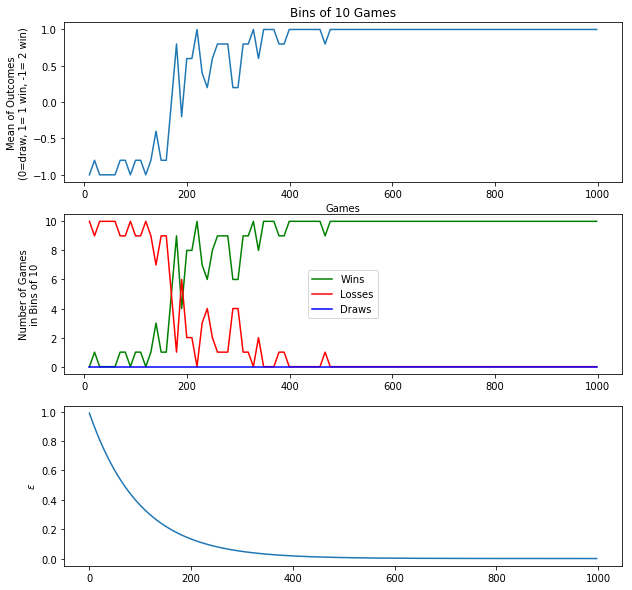

In [75]:
Q1, outcomes = trainQ(1000, 0.2, 0.99, GomokuGame, depthLimit = 3, ploT = True, IDS=True, size=5, limit=5)

Again, Lets check the win rate against different algorithm, and make some comparsion. In testing Q, player 1 will take Q-value orientated move instead of taking random moves!

In [76]:
game = GomokuGame(size=5,limit=5)
print(game)
while not game.isOver():
    _, opponentMove = negamaxIDSab(game, 3)
    # opponentMove = game.getOptMoves(random=True, number=1)[0]
    game.makeMove(opponentMove)
    print('Player', game.player, 'to', opponentMove)
    print(game)
    if(game.checkWinner(1)): print("1(Opponent) won")
    if not game.isOver():
        game.changePlayer()
        validMoves = np.asarray(game.getAllMoves())
        Qs = np.array(list([Q1.get((boardMoveTuple(game.board, m)), 0)] for m in validMoves))
        move = tuple(validMoves[ np.argmax(Qs) ])
        game.makeMove(move)
        print('Player', game.player, 'to', move)
        print(game)
        game.changePlayer()
        if(game.checkWinner(2)): print("2(Agent) won")
print(game.getNumberMovesExplored())

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (2, 2)
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 0)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (1, 3)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 2)
[[ 2.  0.  2.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (3, 1)
[[ 2.  0.  2.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 4)
[[ 2.  0.  2.  0.  2.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (2, 1)
[[ 2.  0.  2.  0.  2.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.

This trained model suffers from the problem that the opponent will not consider agent's move while searching its own highest score. Although the training process was successful, the trained model is silly and not useful at all.

Outcomes: 7162 1 wins 2832 2 wins 6 draws


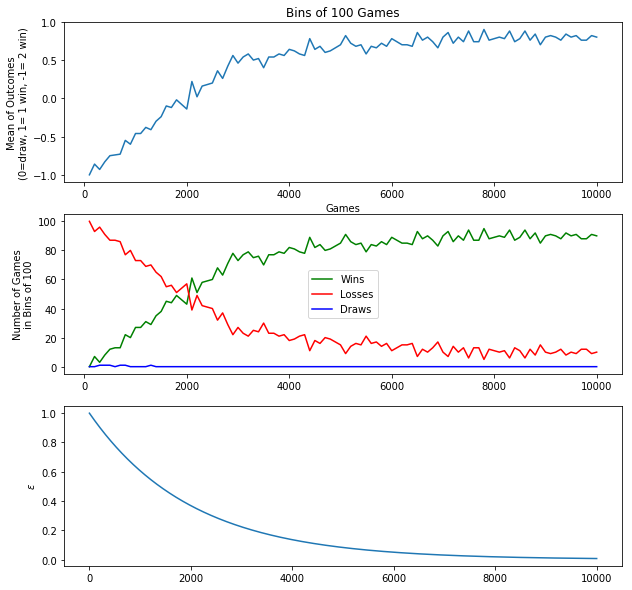

In [77]:
Q2, outcomes = trainQ(10000, 0.2, 0.9995, GomokuGame, depthLimit = 3, ploT = True, IDS=False)

In [78]:
game = GomokuGame(size=5,limit=5)
print(game)
while not game.isOver():
    _, opponentMove = negamaxIDSab(game, 3)
    # opponentMove = game.getOptMoves(random=True, number=1)[0]
    game.makeMove(opponentMove)
    print('Player', game.player, 'to', opponentMove)
    print(game)
    if(game.checkWinner(1)): print("1(Opponent) won")
    if not game.isOver():
        game.changePlayer()
        validMoves = np.asarray(game.getAllMoves())
        Qs = np.array(list([Q2.get((boardMoveTuple(game.board, m)), 0)] for m in validMoves))
        move = tuple(validMoves[ np.argmax(Qs) ])
        game.makeMove(move)
        print('Player', game.player, 'to', move)
        print(game)
        game.changePlayer()
        if(game.checkWinner(2)): print("2(Agent) won")
print(game.getNumberMovesExplored())

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (2, 2)
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 0)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (1, 3)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 1)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (3, 1)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (4, 1)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]]
Player 1 to (4, 0)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.

Outcomes: 7195 1 wins 2801 2 wins 4 draws


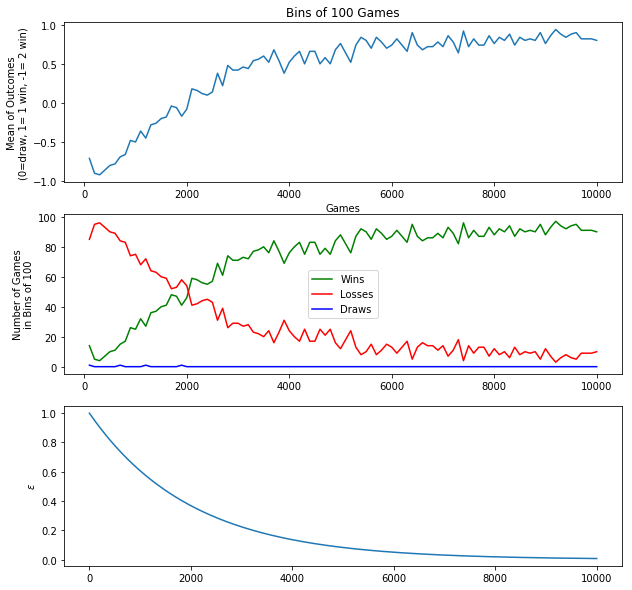

In [79]:
Q3, outcomes = trainQ(10000, 0.2, 0.9995, GomokuGame, depthLimit = 3, ploT = True, IDS=False)

Again, Lets check the win rate against different algorithm, and make some comparsion. In testing Q, player 1 will take Q-value orientated move instead of taking random moves!

In [80]:
game = GomokuGame(size=5,limit=4)
print(game)
while not game.isOver():
    _, opponentMove = negamaxIDSab(game, 3)
    # opponentMove = game.getOptMoves(random=True, number=1)[0]
    game.makeMove(opponentMove)
    print('Player', game.player, 'to', opponentMove)
    print(game)
    if(game.checkWinner(1)): print("1(Opponent) won")
    if not game.isOver():
        game.changePlayer()
        validMoves = np.asarray(game.getAllMoves())
        Qs = np.array(list([Q3.get((boardMoveTuple(game.board, m)), 0)] for m in validMoves))
        move = tuple(validMoves[ np.argmax(Qs) ])
        game.makeMove(move)
        print('Player', game.player, 'to', move)
        print(game)
        game.changePlayer()
        if(game.checkWinner(2)): print("2(Agent) won")
print(game.getNumberMovesExplored())

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (2, 2)
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 0)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (1, 3)
[[ 2.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 1)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (3, 1)
[[ 2.  2.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 2 to (0, 4)
[[ 2.  2.  0.  0.  2.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Player 1 to (3, 2)
[[ 2.  2.  0.  0.  2.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.

Outcomes: 793 1 wins 207 2 wins 0 draws


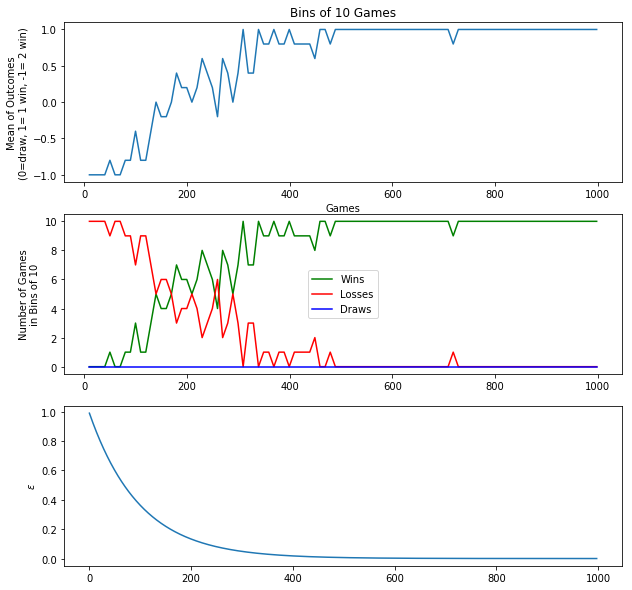

In [26]:
Q4, outcomes = trainQ(1000, 0.2, 0.99, GomokuGame, depthLimit = 3, ploT = True, IDS=True, size=5, limit=4)

In [33]:
def TestQ(Q, depthLimit, nRepetitions):
    
    outcomes = np.zeros(nRepetitions)
    
    for nRep in range(nRepetitions):
        
        global game
        game = GomokuGame(size=5,limit=4)
        done = False
        
        while not done:
            move = randomStratage(game)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            
            if(game.checkWinner(1, move)): 
                outcomes[nRep] = 1
                done = True
            
            if game.isOver() and not done:
                outcomes[nRep] = 0
                done = True
                
            if not done:
                game.changePlayer()
                validMoves = np.asarray(game.getAllMoves())
                Qs = np.array(list([Q.get((boardMoveTuple(game.board, m)), 0)] for m in validMoves))
                opponentMove = tuple(validMoves[ np.argmax(Qs) ])
                game.makeMove(opponentMove)
                game.changePlayer()
                
            if(game.checkWinner(2, opponentMove)): 
                outcomes[nRep] = 2
                done = True
            
            if game.isOver() and not done:
                outcomes[nRep] = 0
                done = True
    return outcomes

In [42]:
outcomes4 = TestQ(Q4,3,5000)

In [43]:
win41 = sum(np.asarray(outcomes4 == 1)) / len(outcomes4)
win42 = sum(np.asarray(outcomes4 == 2)) / len(outcomes4)
print("Using local optimal (negamaxabIDS) algorithm:\n",
      "player 1(Random Move) has win rate :", win41, 
      "\nplayer 2(Q table Orientated) has win rate :", win42)

Using local optimal (negamaxabIDS) algorithm:
 player 1(Random Move) has win rate : 0.1768 
player 2(Q table Orientated) has win rate : 0.8184


In [44]:
def TestRandom(depthLimit, nRepetitions):
    
    outcomes = np.zeros(nRepetitions)
    
    for nRep in range(nRepetitions):
        
        global game
        game = GomokuGame(size=5,limit=4)
        done = False
        
        while not done:
            move = randomStratage(game)
            if move == None :
                print('move is None. Stopping.')
                break
            game.makeMove(move)
            
            if(game.checkWinner(1, move)): 
                outcomes[nRep] = 1
                done = True
            
            if game.isOver() and not done:
                outcomes[nRep] = 0
                done = True
                
            if not done:
                game.changePlayer()
                opponentMove = randomStratage(game)
                game.makeMove(opponentMove)
                game.changePlayer()
                
            if(game.checkWinner(2, opponentMove)): 
                outcomes[nRep] = 2
                done = True
            
            if game.isOver() and not done:
                outcomes[nRep] = 0
                done = True
    return outcomes

In [49]:
outcomes5 = TestRandom(3,5000)
win51 = sum(np.asarray(outcomes5 == 1)) / len(outcomes5)
win52 = sum(np.asarray(outcomes5 == 2)) / len(outcomes5)
print("Using local optimal (negamaxabIDS) algorithm:\n",
      "player 1(Random Move) has win rate :", win51, 
      "\nplayer 2(Random Move) has win rate :", win52)

Using local optimal (negamaxabIDS) algorithm:
 player 1(Random Move) has win rate : 0.5186 
player 2(Random Move) has win rate : 0.4078


### Which is the optimal algorithm based on current score scheme? 

1. local optimal (negamaxabIDS) algorithm
2. move with highest score in the board
3. random move in top # highest moves
4. Q-Table orientated algorithm
5. random Stratage

| Test Iterations | Type 1 Win Rate| Type 2 Win Rate | Type 3 Win Rate | Q-Table Win Rate | Random Win Rate |
|-----------------|--------|--------|--------|--------|--------|
| 100 | 1.0 | 0.99 | 0.88 | 0.83 |  0.42 |
| 500 | 0.996 | 0.996 | 0.864 | 0.834 | 0.382 |
| 1000 | 0.992 | 0.993 | 0.871 | 0.823 | 0.393 |
| 5000 | 0.9938 | 0.9934 | 0.8774 | 0.8184 | 0.4094 |

### Summary

The training process is successful to build a model playing against opponent using best move according to current score scheme. The trained model has gain some knowledge on how to play Gomuku game while the trained model is not good enough for general cases.